In [1]:
import json
import pandas as pd
from flatten_json import flatten
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,auc,roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy
%matplotlib inline

At high level, we will follow below steps to build our spam classifier for rss newsfeeds:
> __1. Dataset Preparation:__ The first step is the Dataset Preparation step which includes the process of loading a dataset and performing basic pre-processing. The dataset is then splitted into train and validation sets. We will read scraped news from json, extract the information we need and create label ( spam or ham )

> __2. Feature Engineering:__ The next step is the Feature Engineering in which the raw dataset is transformed into flat features which can be used in a machine learning model. This step also includes the process of creating new features from the existing data. 

> __3. Model Training:__ The final step is the Model Building step in which a machine learning model is trained on a labelled dataset.

> __4. Improve Performance of Spam Classifier:__ We will also lexplore the different ways to improve the performance of text classifiers.





# 1 Data Preparation

We have list of domains which are blacklisted. After analysing the structure of the scraped news articles in JSON format, we can use these blacklisted domains to identfy particular article as Spam or not spam ( aka 'ham')

Let's create labels as :

- __0__ NOT SPAM (aka 'ham' )
- __1__ SPAM


In [2]:
blacklist = [
  "nbpostgazette.com",
  "www.ratingsalerts.com",
  "theanalystfinancial.com",
  "marketingcorrect.com",
  "dailytelescope.com",
  "nbherard.com",
  "financialportal24.com",
  "reportagestuff.com",
  "www.insidertradings.org",
  "silverpinyon.com",
  "timegazette.com",
  "www.satprnews.com",
  "monotonecritic.com",
  "marketnewsaccess.com",
  "firstnewsservice.com",
  "yourniskayuna24.com",
  "nwctrail.com",
  "ibnservice.com",
  "incrediblenews24.com",
  "publicsector24.com",
  "firstnewshawk.com",
  "journalismday.com",
  "www.highlandmirror.com",
  "thetricountypress.com",
  "assetsstock.com",
  "chiefobserver.com",
  "opinioninvestor.com",
  "freenewsman.com",
  "talkherald.com",
  "publicistreport.com",
  "newmexicocourierexpress.com",
  "peopletoday24.com",
  "dailycommercenews.com",
  "factsweek.com",
  "thefuturetechnologies.com",
  "newschemicals.com",
  "thefinancialconsulting.com",
  "islandpostgazette.com",
  "therealfact24.com",
  "thefuturetechnologies.com",
  "perfectanalyst.com",
  "positivenewspaper.com",
  "www.findmarketresearch.org",
  "talkdailynews.com",
  "ittechnology24.com",
  "heraldanalyst.com",
  "tokenfolks.com",
  "theanalystfinancial.com",
  "truthfulreporter.com",
]

In [3]:
def isspam(link):
    # if the link field contains any of the blacklisted domain names, label this as spam
    spam = 0
    for x in blacklist:
        if link.lower().find(x.lower())!= -1:
            spam =1
    return spam

### Read the news articles  from JSON file into the DataFrame:

In [4]:
def read_data_from_json():
    articles = open('scraped_articles.json', 'r')
    data = json.load(articles)
    col1_l,col2_l,col3_l,col4_l,col5_l,label = [],[],[],[],[],[]
    for col1 in data.keys():
        for col2 in data[col1].keys():
            for col3 in data[col1][col2].keys():
                for col4 in data[col1][col2][col3]:
                    for article in data[col1][col2]['articles']:
                        col1_l.append(article['link'])
                        col2_l.append(article['published'])
                        col3_l.append(article['title'])
                        col4_l.append(article['text'])
                        col5_l.append(article['author'])
                        label.append(isspam(article['link']))
                    #col4_l.append(data[col1][col2][col3])

    data=pd.DataFrame([col1_l,col2_l,col3_l,col4_l,col5_l,label]).T
    data.columns =['link','published','title','text','author','label']
    return data


In [5]:
data = read_data_from_json()

### Lets take a sneak peek at how our data looks like to humans before we transform it into vectorized features suitable for downstream algorithms

In [6]:
data.head()

,link,published,title,text,author,label
0,https://www.nytimes.com/2018/03/24/technology/...,2018-03-24T20:43:21,How Calls for Privacy May Upend Business for F...,"There are other avenues still, said Jascha Kay...","[David Streitfeld, Natasha Singer, Steven Erla...",0
1,https://www.nytimes.com/2018/03/24/business/we...,2018-03-24T17:16:53,The Former Khmer Rouge Slave Who Blew the Whis...,"And so Mr. Tran, who is in his mid-50s and spe...",[Emily Flitter],0
2,https://www.nytimes.com/2018/03/25/business/ch...,2018-03-25T15:21:56,"China Splits Top Jobs at Central Bank, Adding ...","In that analogy, Mr. Guo will essentially beco...",[Keith Bradsher],0
3,https://www.nytimes.com/2018/03/24/business/jo...,2018-03-25T03:00:18,A Top Candidate for New York Fed’s Leader: San...,News of Mr. Williams’s likely selection was fi...,[Ben Casselman],0
4,https://www.nytimes.com/2018/03/24/business/tr...,2018-03-24T14:34:10,"Trump’s Tariffs Keep Allies, Markets and Indus...",What is increasingly clear to many on Capitol ...,[Jim Tankersley],0


### features we can use:
It seems we can use both 'title' and 'text' from the news articles in order to train our spam classifier. We can also use Author names as one of the features. However, let's first start with the most important field ('text') and see if we can build an accurate classifier. We will come back to consider other features, if our model is not doing too well just using the 'text' column.

### Is our target variable too imbalanced?

Let’s see how much is the imbalance in number of spam and ham articles. 
All the machine learning models try to minimize error on training data. If the number of spams are too low as compared to regular article, our classifier will just start predicting everything as 'Not spam' and still maintain high accuracy. We don't want that to happen. If the imbalance is too high ( minority class is less than 15% of the majority class) we will need to employ methods like oversampling/ undersamling or SMOTE to  balance our data

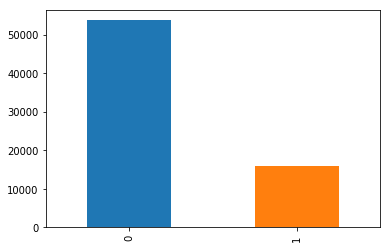

In [7]:
data['label'].value_counts().plot(kind='bar')

#### This looks like  imbalanced class. However, it is not too imbalanced i.e. the enemble models should still work well and oversampling/SMOTE is not necessary. We will have to revisit this in case our model doesn't perform too well

In [8]:
# Lets create copy of our data to start transforming the same
df = data.copy()

## 1.2 Feature Selection

In [9]:
#drop (currently) unused columns
df.drop(['link','published','title','author'],axis = 1,inplace=True)

In [10]:
df.rename({'text':'data','label':'labels'},axis=1,inplace=True)

In [11]:
# change to sklearn- friendly data type
df.labels = df.labels.astype(int)

In [12]:
Y = df['labels'].values

# 2. Feature Engineering
The next step is the Feature Engineering in which the raw dataset is transformed into flat features which can be used in a machine learning model. This step also includes the process of creating new features from the existing data.

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

We can use below feature engineering techniques for our data:

### 2.1 Count Vectors as features:

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

### 2.2 TF-IDF Vectors as features:

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)



> __a. Word Level TF-IDF__ : Matrix representing tf-idf scores of every term in different documents

> __b. N-gram Level TF-IDF__ : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

> __c. Character Level TF-IDF__ : Matrix representing tf-idf scores of character level n-grams in the corpus

2.3 Word Embeddings as features

2.4 Text / NLP based features

2.5 Topic Models as features


In [13]:

#count_vectorizer = CountVectorizer(decode_error='ignore')

In [14]:
#tfidf_vectorizer = TfidfVectorizer() # This can work much better than Countvectorizer even without removing stop words

In [15]:
X = df['data']

In [16]:
# split up the data into training and test set
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)

In [17]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word')


# transform the training and validation data using count vectorizer object
xtrain_count  =  count_vect.fit_transform(Xtrain)
xvalid_count  =  count_vect.transform(Xtest)

In [18]:
# word level tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(Xtrain)
xtrain_tfidf =  tfidf_vect.transform(Xtrain)
xvalid_tfidf =  tfidf_vect.transform(Xtest)

In [19]:
xtrain_tfidf.shape

(46580, 22219)

In [20]:
xvalid_tfidf.shape

(22943, 22219)

In [21]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=8000)
tfidf_vect_ngram.fit(Xtrain)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(Xtrain)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(Xtest)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=8000)
tfidf_vect_ngram_chars.fit(Xtrain)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(Xtrain) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(Xtest) 

## We can also use word embeddings/LDA topic models as features
### About Word embedding

It’s a means of building a low-dimensional vector representation from corpus of text, which preserves the contextual similarity of words.

Basically, it is the transformation of text into numbers. So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by ML algorithms, this vector representation has two important and advantageous properties:

1.	Dimensionality Reduction - it is a more efficient representation

2.	Contextual Similarity - it is a more expressive representation

Why word embedding?

●	It is necessary because many machine learning algorithms (including deep nets) require their input to be vectors of continuous values; they just won’t work on strings of plain text.

●	Representing words as unique, discrete ids furthermore leads to data sparsity, and usually means that we may need more data in order to successfully train statistical models. Using vector representations can overcome some of these obstacles.

●	Vector Space Models embedded words in a continuous vector space where semantically similar words are embedded nearby each other. 

Implementation models:

●	__Word2Vec:__ It is a predictive based model: Predictive models learn their vectors in order to improve their predictive ability of Loss (target word | context words; Vectors), i.e. the loss of predicting the target words from the context words given the vector representations. In word2vec, this is cast as a feed-forward neural network and optimized as such using SGD, etc

●	__Glove:__ It is a count based model: Count-based models learn their vectors by essentially doing dimensionality reduction on the co-occurrence counts matrix. This is done by minimizing a "reconstruction loss" which tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data. In the specific case of GloVe, the counts matrix is pre-processed by normalizing the counts and log-smoothing them
We must keep in mind that Word2vec is a two-layer shallow neural net and  techniques like Word2vec and GloVe can turn raw text into a numerical form that deep nets can understand.

### About LDA topic modeling:

As the name suggests, it is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Thus, assisting better decision making.

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.

Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. For Example – New York Times are using topic models to boost their user – article recommendation engines. Various professionals are using topic models for recruitment industries where they aim to extract latent features of job descriptions and map them to right candidates. They are being used to organize large datasets of emails, customer reviews, and user social media profiles.


Refernce: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [22]:
def model_accuracy(classifier, Xtrain, Ytrain, Xtest,Ytest):
    # fit the training dataset on the classifier
    classifier.fit(Xtrain, Ytrain)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(Xtest)
    
    print('Model accuracy:',accuracy_score(predictions, Ytest))
    fpr, tpr, thresholds = roc_curve(Ytest, predictions, pos_label=1)
    print('Area Under ROC curve: ', auc(fpr, tpr))
    print('F-1 Score: ',f1_score( Ytest,predictions))
    print('Confusion Matrix:\n',confusion_matrix(predictions, Ytest))

In [23]:
def model_accuracy_all_features(classifier):
    print('**********************************************')
    print('Using count vectors:')
    model_accuracy(classifier,xtrain_count,Ytrain,xvalid_count,Ytest)
    print('**********************************************')
    print('Using tf-idf word vectors:')
    model_accuracy(classifier, xtrain_tfidf, Ytrain, xvalid_tfidf,Ytest)
    print('**********************************************')
    print('Using tf-idf N gram vectors:')
    model_accuracy(classifier, xtrain_tfidf_ngram, Ytrain, xvalid_tfidf_ngram,Ytest)
    print('**********************************************')
    print('Using tf-idf N gram Character vectors:')
    model_accuracy(classifier, xtrain_tfidf_ngram_chars, Ytrain, xvalid_tfidf_ngram_chars,Ytest)
    

In [24]:
#cv = sklearn.model_selection.KFold(n_splits=10)

In [25]:
#Xtrain_tfidf  =tfidf_vectorizer.fit_transform(Xtrain)

In [26]:
#Xtrain_tfidf.shape

In [27]:
#Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [28]:

nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
lr = LogisticRegression(solver='liblinear',n_jobs=-1)
svc = SVC()
xgb = XGBClassifier(n_estimators=500,n_jobs=-1)

In [29]:
# create the model, train it, print scores
model_accuracy_all_features(nb)

**********************************************
Using count vectors:
Model accuracy: 0.9984744802336225
Area Under ROC curve:  0.9966583922092801
F-1 Score:  0.9966471884280104
Confusion Matrix:
 [[17706    35]
 [    0  5202]]
**********************************************
Using tf-idf word vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram vectors:
Model accuracy: 0.9954670269799067
Area Under ROC curve:  0.9900706511361467
F-1 Score:  0.9899710703953712
Confusion Matrix:
 [[17706   104]
 [    0  5133]]
**********************************************
Using tf-idf N gram Character vectors:
Model accuracy: 0.9954670269799067
Area Under ROC curve:  0.9900706511361467
F-1 Score:  0.9899710703953712
Confusion Matrix:
 [[17706   104]
 [    0  5133]]


In [30]:
model_accuracy_all_features(rf)

**********************************************
Using count vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf word vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram Character vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]


In [31]:
model_accuracy_all_features(lr)

**********************************************
Using count vectors:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf word vectors:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram vectors:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram Character vectors:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]


In [32]:
#model_accuracy_all_features(svc)

In [33]:
model_accuracy_all_features(xgb)

**********************************************
Using count vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf word vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]
**********************************************
Using tf-idf N gram Character vectors:
Model accuracy: 1.0
Area Under ROC curve:  1.0
F-1 Score:  1.0
Confusion Matrix:
 [[17706     0]
 [    0  5237]]


nb: 1.000000 (0.000000)
rf: 1.000000 (0.000000)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklea

lr: 1.000000 (0.000000)
xgb: 1.000000 (0.000000)


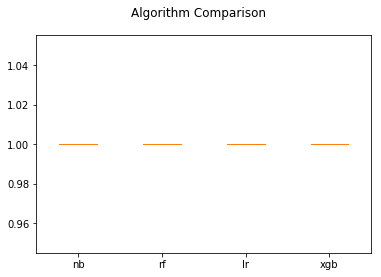

In [34]:
models = []
models.append(('nb', MultinomialNB()))
models.append(('rf', RandomForestClassifier(n_estimators=500,n_jobs=-1)))
models.append(('lr', LogisticRegression(solver='liblinear',n_jobs=-1)))
models.append(('xgb', XGBClassifier(n_estimators=500,n_jobs=-1)))
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, xtrain_tfidf, Ytrain, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

nb: 0.995341 (0.000768)
rf: 1.000000 (0.000000)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklea

lr: 1.000000 (0.000000)
xgb: 1.000000 (0.000000)


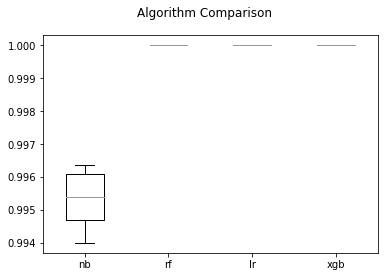

In [35]:
models = []
models.append(('nb', MultinomialNB()))
models.append(('rf', RandomForestClassifier(n_estimators=500,n_jobs=-1)))
models.append(('lr', LogisticRegression(solver='liblinear',n_jobs=-1)))
models.append(('xgb', XGBClassifier(n_estimators=500,n_jobs=-1)))
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, xtrain_tfidf_ngram, Ytrain, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Feature Importance

> In our case  feature importance means words which give us most information to determine given news is spam or not

> We can use Random Forest to determine such words. Let's train the model on all available data to capture everything


In [36]:
tfidf_all = TfidfVectorizer(stop_words='english')

In [37]:
X_tfidf = tfidf_all.fit_transform(X)

In [38]:
rf_all = RandomForestClassifier(n_estimators=500)

In [39]:
rf_all.fit(X_tfidf,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
feature_names = np.array(tfidf_all.get_feature_names())

In [41]:
sorted_coef_index = rf_all.feature_importances_.argsort()

In [42]:
feature_names[sorted_coef_index[-150:]]

#Below is the list of top 150 importance words

array(['chapter', 'reports', 'appendix', 'provides', 'contains', 'gross',
       'gathered', 'percent', 'types', 'expected', 'future', 'gives',
       'southeast', 'presents', 'databases', 'adoption', 'focuses',
       'swot', 'profit', 'long', 'volume', 'downstream', 'evaluates',
       'analysts', 'sub', 'segment', 'secondary', 'japan', '2018',
       'methodology', 'marketing', 'till', 'status', 'details',
       'complete', 'interviews', 'year', 'fiormarkets', 'people', 'time',
       'statistics', 'terms', 'display', 'price', 'research',
       'segmentation', 'vendors', 'geographical', 'upstream', 'cost',
       'restraints', 'globally', 'equipment', 'proposals', 'contact',
       'sales', 'raw', 'aspects', 'capacity', 'channels', 'value', 'end',
       'qualitative', 'includes', 'conclusion', 'development', 'rate',
       'owing', 'evaluation', 'scope', 'said', 'developments',
       'countries', 'challenges', 'competitive', 'comprehensive', 'cagr',
       'samples', 'segmented'

# Model Deployment as REST API

### Let's deploy our Random Forest Classfier above as an API

In [43]:
# Let's use one spam news article and one non- spam news article to test our deployed API
teststr_spam =str(df[df['labels']==1]['data'].iloc[0])
teststr_ham =str(df[df['labels']==0]['data'].iloc[0])

In [44]:
teststr_spam

'Questale released a detailed assessment of trends in Fuel Dispensers market. The research report includes diverse topics like total market size, key market drivers, challenges, growth opportunities, key players etc. We have also covered key market updates, the impact of regulations and technological updates in ,, . New startups entering the space of Fuel Dispensers need to carefully pick their niches and genres so that they can compete on an equal footing with global companies who have an end to end development studios, production capabilities and global skills and experience backing them.\n\nThe research will provide a forecast for Fuel Dispensers market till 2022. The report is vital for anyone involved in the Fuel Dispensers industry. The study gives a very comprehensive outlook of the entire ,, markets.\n\nYou can get free access to samples from the report here: https://questale.com/report/fuel-dispensers-market-report-by-company-regions-types-and-applications-global-status-and-fo

In [45]:
teststr_ham

"There are other avenues still, said Jascha Kaykas-Wolff, the chief marketing officer of Mozilla, the nonprofit organization behind the popular Firefox browser, including advertisers and large tech platforms collecting vastly less user data and still effectively customizing ads to consumers.\n\n“They are just collecting all the data to try to find magic growth algorithms,” Mr. Kaykas-Wolff said of online marketers. This past week, Mozilla halted its ads on Facebook, saying the social network’s default privacy settings allowed access to too much data.\n\nThe greatest likelihood is that the internet companies, frightened by the tumult, will accept a few more rules and work a little harder for transparency. And there will be hearings on Capitol Hill.\n\nThe next chapter is also set to play out not in Washington but in Europe, where regulators have already cracked down on privacy violations and are examining the role of data in online advertising.\n\nPhoto\n\nThe Cambridge Analytica case, 

In [46]:
# Lets use one news with few sentences from a Spam news
test_spam_proba = """report contains company profiling along with Fuel Dispensers market share, sales figures, product specifications and pictures of the products offered by top companies. It also includes the contact information of all local, regional and international vendors for the composite materials market in the ,,.\n\nWith growing competition in the market, both local and regional competitors have come head to head with each other. They are engaging in M&A activities and technological innovation to gain an edge over their competition for finding the largest share of end-users.\n\nNew vendors in the market are facing tough competition from established international vendors as they struggle with technological innovations, reliability and quality issues. The report will answer questions about the current market developments and the scope of competition, opportunity cost and more.\n\nKey questions answered in Fuel Dispensers market research report:\n\nThe report answers several questions about the composite materials market. These questions include:\n\nWhat will be the market size of composite materials market in 2022?\n\nWhat will be the composite materials growth rate in 2022?\n\nWhich key factors drive the composite materials market in the EMEA?\n\nWho are the key market players for composite materials in the EMEA?\n\nWhich strategies are used by top players in the composite materials market?\n\nWhat are the key market trends in composite materials in the EMEA>\n\nWhich trends and challenges will influence the growth or composite materials market?\n\nWhich barriers do the composite materials markets face?\n\nWhat are the market opportunities for vendors in the EMEA and what are the threats faced by them?\n\nWhat are the most important outcomes of the five forces analysis of the composite materials market in the EMEA?\n\nThe report also contains new project investment feasibility analysis for users.\n\nThank you for reading the report. You can find the more detailed report here or request us for customization by contacting us.\n\nFeel free to get in touch for discounts and customized details"""

In [47]:
from sklearn.externals import joblib
joblib.dump(rf_all, 'model.pkl')

['model.pkl']

In [48]:
joblib.dump(tfidf_all, 'tfidf.pkl')

['tfidf.pkl']

## We  have trsnfered our .pkl objects to my AWS server which explose our model as REST API using flask using below code

In [49]:
# from flask import Flask, jsonify,request
# from sklearn.externals import joblib
# import pandas as pd
# import numpy as np

# app = Flask(__name__)
# clf = joblib.load('model.pkl')
# tfidf = joblib.load('tfidf.pkl')

# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json(force=True)
#     features =tfidf.transform(np.array([data['news']]))
#     prediction =clf.predict(features)
#     spam_probability = clf.predict_proba(features)[0][1]
#     output = str(prediction[0])
#     return jsonify(IsSpam = output,spam_probability =spam_probability)
# if __name__ == '__main__':
#      app.run(host= '0.0.0.0',port=8899)

# Deployed REST API : http://varunpatwardhan.com:8899/predict

# Testing our API with a Spam news

In [50]:
import requests

url = "http://varunpatwardhan.com:8899/predict"
data = json.dumps({'news':teststr_spam})
r = requests.post(url,data)

r.json()

{'IsSpam': '1', 'spam_probability': 1.0}

# Testing our API with a non-spam news

In [51]:

data = json.dumps({'news':teststr_ham})
r = requests.post(url,data)

r.json()

{'IsSpam': '0', 'spam_probability': 0.0}

# Testing our model and API with partial text from Spam

In [52]:
data = json.dumps({'news':test_spam_proba})
r = requests.post(url,data)

r.json()

{'IsSpam': '0', 'spam_probability': 0.444}

In [53]:
# print("train score:", model.score(Xtrain_tfidf, Ytrain))

# print("test score:", model.score(Xtest_tfidf, Ytest))


In [54]:
# Ypred = model.predict(Xtest_tfidf)

# confusion_matrix(Ypred,Ytest)

# rf = RandomForestClassifier(n_estimators=500)

# rf.fit(Xtrain_tfidf,Ytrain)

# Ypred = rf.predict(Xtest_tfidf)

# confusion_matrix(Ypred,Ytest)

In [57]:
# visualize the data
def visualize(label):
  words = ''
  for news in df[df['labels'] == label]['data']:
    news = news.lower()
    words += news + ' '
  wordcloud = WordCloud(width=3600, height=2400).generate(words)
  plt.figure( figsize=(20,10) )
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  plt.savefig('spam_words.jpg')

In [59]:
# # things that should be spam
# sneaky_spam = df[(df['predictions'] == 0) & (df['labels'] == 1)]['data']
# for msg in sneaky_spam:
#   print(msg)

In [60]:
# # things that should not be spam
# not_actually_spam = df[(df['predictions'] == 1) & (df['labels'] == 0)]['data']
# for msg in not_actually_spam:
#   print(msg)

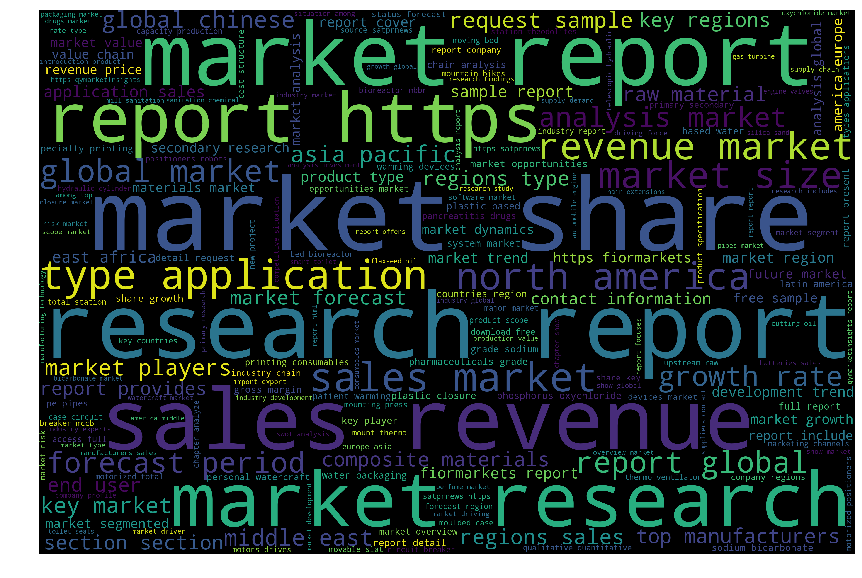

<Figure size 432x288 with 0 Axes>

In [61]:
visualize(1) #Spam

In [ ]:
#visualize(0) #ham